# SHAP Interpretability Analysis

This notebook performs SHAP (SHapley Additive exPlanations) analysis on the tuned XGBoost model and trained LSTM model for glucose prediction interpretability.


In [26]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

warnings.filterwarnings("ignore")

# Add paths for imports
sys.path.append("training")
sys.path.append("tuning")

# Import existing functions
from split_data import load_splits, rescale_data, U_BOUND, L_BOUND


# Set style for plots
plt.style.use("default")
sns.set_palette("husl")

print("Libraries imported successfully")
print(f"SHAP version: {shap.__version__}")

Libraries imported successfully
SHAP version: 0.48.0


## Configuration and Setup


In [27]:
# Configuration
config = {
    "output_dir": "outputs",
    "plots_dir": "plots",
    "splits_dir": "training/splits",
    "models": {"xgb_tuned": "xgb_tuned.pickle"},
    "sample_sizes": {
        "background": 1000,  # For SHAP explainer background
        "explanation": 500,  # For generating explanations
    },
    "random_seed": 42,
}

# Create output directories
os.makedirs(config["plots_dir"], exist_ok=True)
shap_plots_dir = f"{config['plots_dir']}/shap_analysis"
os.makedirs(shap_plots_dir, exist_ok=True)

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Set random seeds
np.random.seed(config["random_seed"])

Configuration:
  output_dir: outputs
  plots_dir: plots
  splits_dir: training/splits
  models: {'xgb_tuned': 'xgb_tuned.pickle'}
  sample_sizes: {'background': 1000, 'explanation': 500}
  random_seed: 42


## Load Data and Models


In [28]:
# Load data splits
print("Loading data splits...")
train_set, val_set, test_set, X_cols, y_cols = load_splits(config["splits_dir"])

print(f"Data loaded successfully:")
print(f"  Train set: {train_set.shape}")
print(f"  Validation set: {val_set.shape}")
print(f"  Test set: {test_set.shape}")
print(f"  Features: {len(X_cols)}")
print(f"  Target: {y_cols}")
print(f"  Feature names: {X_cols}")

Loading data splits...
Data loaded successfully:
  Train set: (14058224, 12)
  Validation set: (1861178, 12)
  Test set: (3945594, 12)
  Features: 8
  Target: ['lead30']
  Feature names: ['lag105', 'lag90', 'lag75', 'lag60', 'lag45', 'lag30', 'lag15', 'lag0']


In [29]:
def load_xgb_tuned_model():
    """Load the tuned XGBoost model"""
    model_path = f"{config['output_dir']}/{config['models']['xgb_tuned']}"

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"XGBoost tuned model not found at {model_path}")

    with open(model_path, "rb") as f:
        model = pickle.load(f)

    print(f"XGBoost tuned model loaded from {model_path}")
    print(f"Model type: {type(model)}")

    return model


# Load models
print("\n" + "=" * 60)
print("LOADING MODELS")
print("=" * 60)

xgb_model = load_xgb_tuned_model()


LOADING MODELS
XGBoost tuned model loaded from outputs/xgb_tuned.pickle
Model type: <class 'xgboost.sklearn.XGBRegressor'>


## Prepare Data for SHAP Analysis


In [30]:
def prepare_shap_data():
    """Prepare data for SHAP analysis"""
    print("\nPreparing data for SHAP analysis...")

    # Combine all datasets for comprehensive analysis
    combined_data = pd.concat([train_set, val_set, test_set], ignore_index=True)
    print(f"Combined dataset shape: {combined_data.shape}")

    # Sample background data for SHAP explainer
    background_indices = np.random.choice(
        len(combined_data),
        size=min(config["sample_sizes"]["background"], len(combined_data)),
        replace=False,
    )
    background_data = combined_data.iloc[background_indices]

    # Sample explanation data
    explanation_indices = np.random.choice(
        len(val_set),
        size=min(config["sample_sizes"]["explanation"], len(val_set)),
        replace=False,
    )
    explanation_data = val_set.iloc[explanation_indices]

    print(f"Background data shape: {background_data.shape}")
    print(f"Explanation data shape: {explanation_data.shape}")

    return combined_data, background_data, explanation_data


# Prepare data
combined_data, background_data, explanation_data = prepare_shap_data()

# Prepare data for models
print("\nPreparing model-specific data...")

# For XGBoost (tabular data)
X_background_xgb = background_data[X_cols]
X_explanation_xgb = explanation_data[X_cols]

print(f"XGBoost data shapes: {X_background_xgb.shape}, {X_explanation_xgb.shape}")


Preparing data for SHAP analysis...
Combined dataset shape: (19864996, 12)
Background data shape: (1000, 12)
Explanation data shape: (500, 12)

Preparing model-specific data...
XGBoost data shapes: (1000, 8), (500, 8)


## XGBoost SHAP Analysis



XGBoost SHAP ANALYSIS
Creating XGBoost TreeExplainer...
Calculating SHAP values...
SHAP values shape: (500, 8)
Base value: -0.3190

Generating XGBoost SHAP plots...


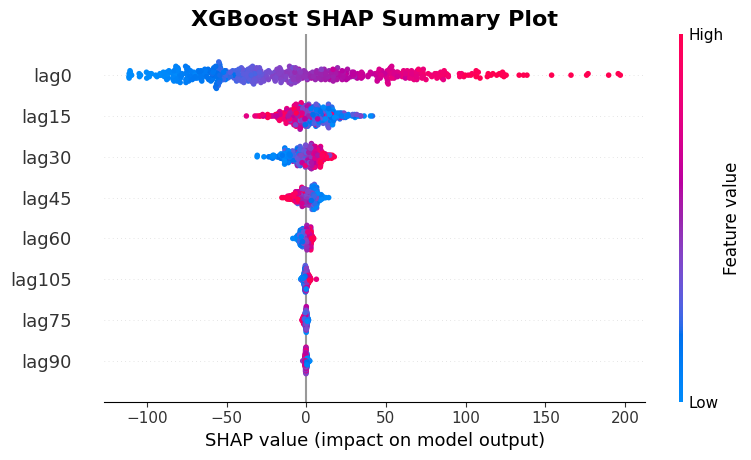

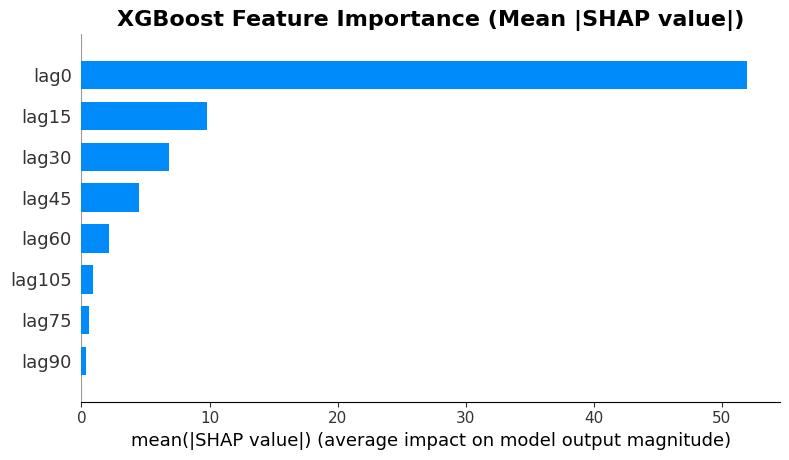


Generating waterfall plots for extreme predictions...


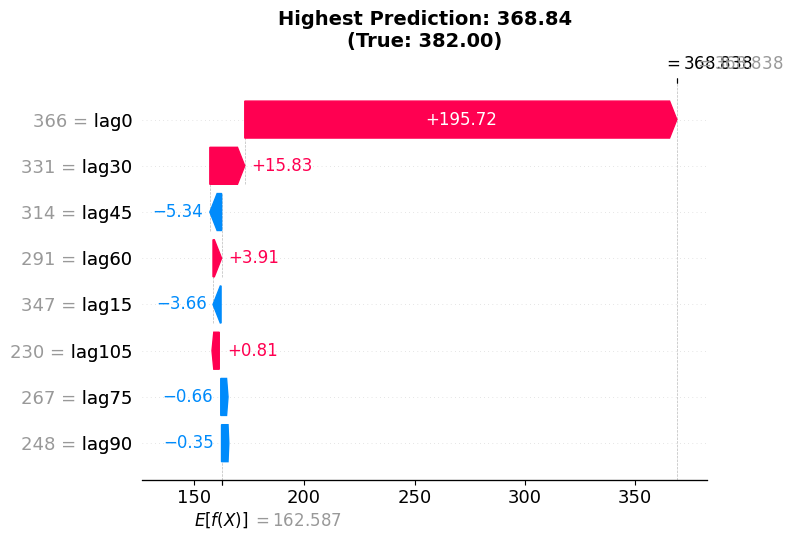

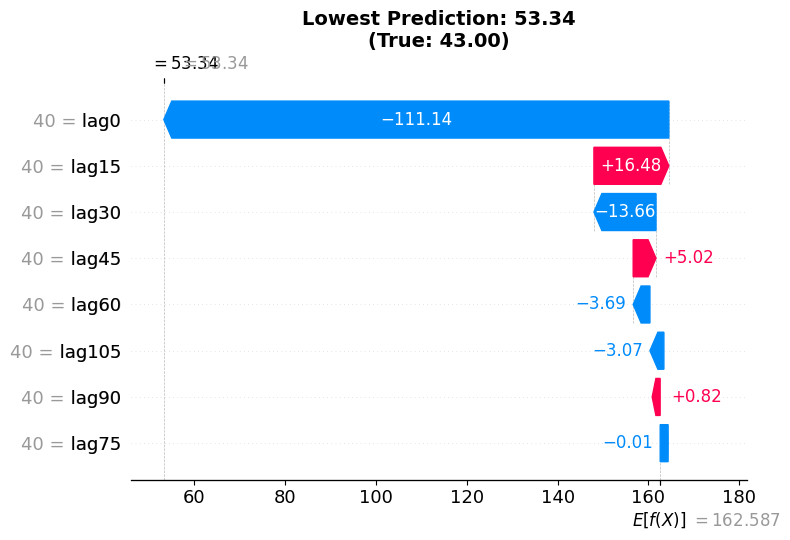


Generating dependence plots for top features...


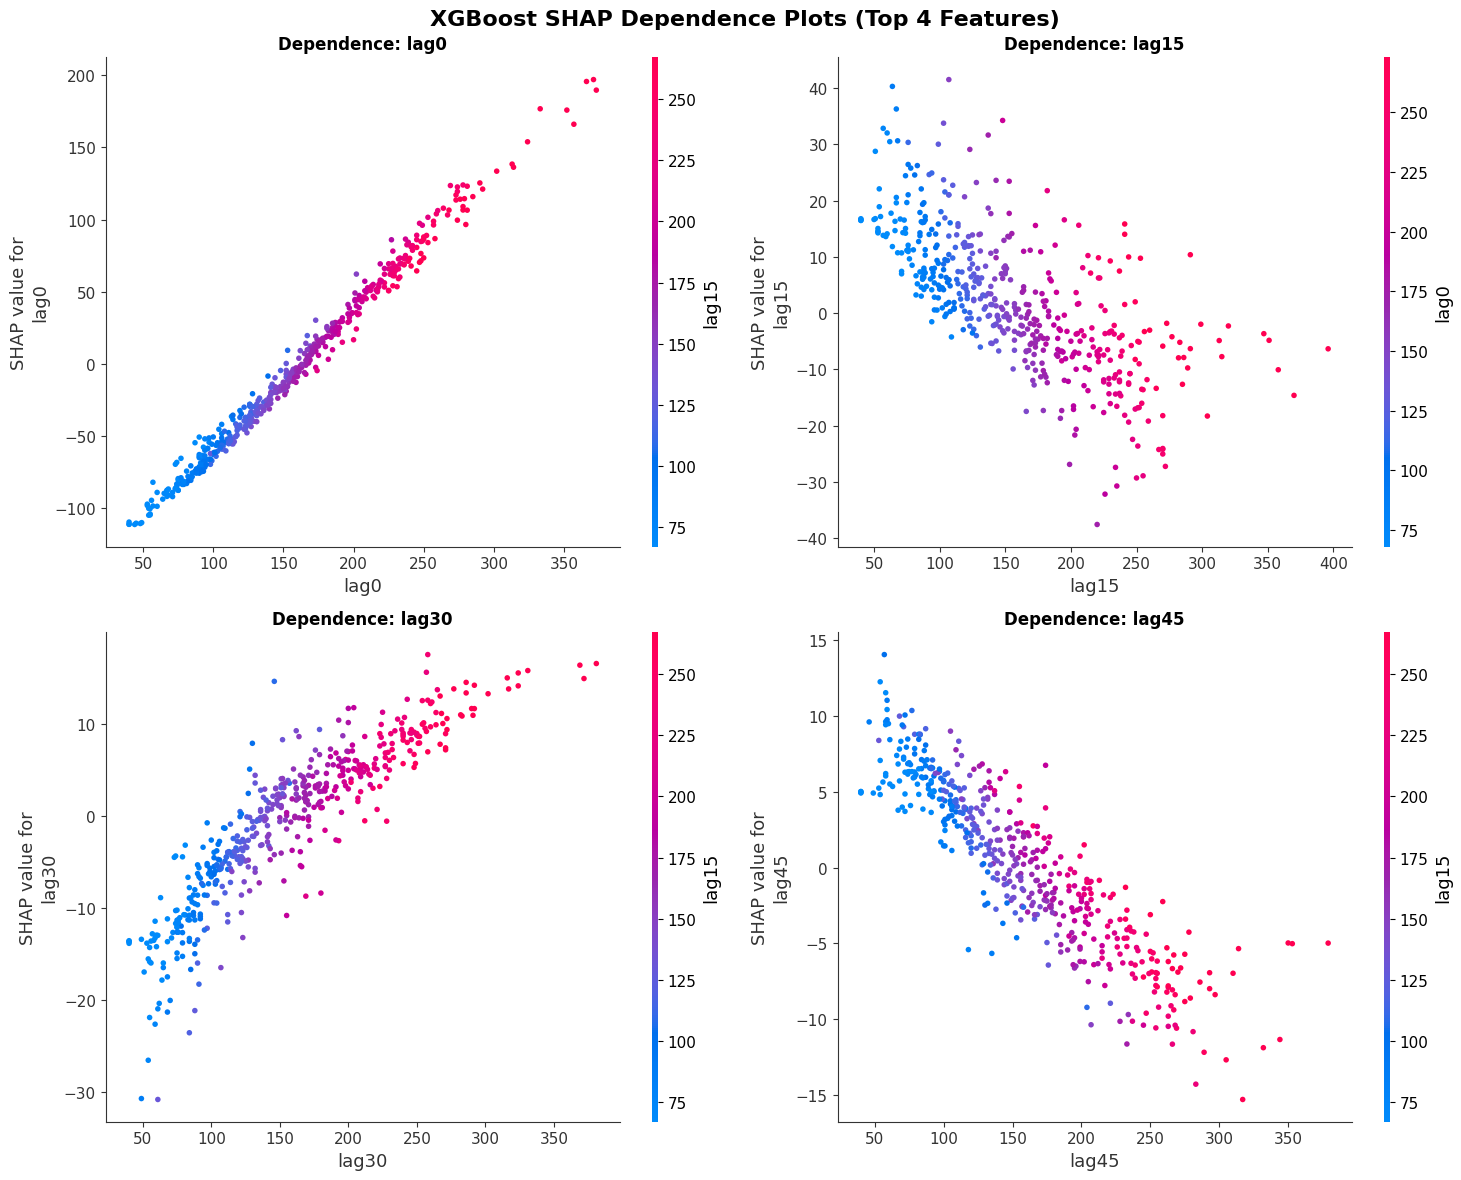

In [31]:
def analyze_xgb_shap():
    """Perform SHAP analysis for XGBoost model"""
    print("\n" + "=" * 60)
    print("XGBoost SHAP ANALYSIS")
    print("=" * 60)

    # Create SHAP explainer (TreeExplainer for XGBoost)
    print("Creating XGBoost TreeExplainer...")
    explainer = shap.TreeExplainer(xgb_model)

    # Calculate SHAP values
    print("Calculating SHAP values...")
    shap_values = explainer.shap_values(X_explanation_xgb)

    print(f"SHAP values shape: {shap_values.shape}")
    print(f"Base value: {explainer.expected_value:.4f}")

    return explainer, shap_values


def plot_xgb_shap_analysis(explainer, shap_values):
    """Generate comprehensive SHAP plots for XGBoost"""
    print("\nGenerating XGBoost SHAP plots...")

    # Rescale feature data back to original range for visualization
    X_explanation_rescaled = rescale_data(X_explanation_xgb, X_cols)

    # Calculate scaling factor for SHAP values
    # SHAP values need to be scaled with the same factor as the target
    scale_factor = (U_BOUND - L_BOUND) / 2  # From rescale_data function
    shap_values_rescaled = shap_values * scale_factor

    # Rescale base value too
    base_value_rescaled = explainer.expected_value * scale_factor + (
        (U_BOUND + L_BOUND) / 2
    )

    # 1. Summary plot (feature importance)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values_rescaled, X_explanation_rescaled, feature_names=X_cols, show=False
    )
    plt.title("XGBoost SHAP Summary Plot", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.savefig(f"{shap_plots_dir}/xgb_shap_summary.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 2. Bar plot (mean absolute SHAP values)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_rescaled,
        X_explanation_rescaled,
        feature_names=X_cols,
        plot_type="bar",
        show=False,
    )
    plt.title(
        "XGBoost Feature Importance (Mean |SHAP value|)", fontsize=16, fontweight="bold"
    )
    plt.tight_layout()
    plt.savefig(f"{shap_plots_dir}/xgb_shap_bar.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 3. Waterfall plot for top predictions
    print("\nGenerating waterfall plots for extreme predictions...")

    # Get predictions and find extreme cases (rescale predictions too)
    predictions_scaled = xgb_model.predict(X_explanation_xgb)
    predictions_rescaled = rescale_data(
        pd.DataFrame({"pred": predictions_scaled}), ["pred"]
    )["pred"].values

    # Rescale true values
    y_true_rescaled = rescale_data(
        pd.DataFrame({"target": explanation_data[y_cols[-1]].values}), ["target"]
    )["target"].values

    # Find highest and lowest predictions (use rescaled values)
    highest_pred_idx = np.argmax(predictions_rescaled)
    lowest_pred_idx = np.argmin(predictions_rescaled)

    # Create SHAP Explanation objects for waterfall plots (use rescaled data AND rescaled SHAP values)
    explanation_highest = shap.Explanation(
        values=shap_values_rescaled[highest_pred_idx],
        base_values=base_value_rescaled,
        data=X_explanation_rescaled.iloc[highest_pred_idx].values,
        feature_names=X_cols,
    )

    explanation_lowest = shap.Explanation(
        values=shap_values_rescaled[lowest_pred_idx],
        base_values=base_value_rescaled,
        data=X_explanation_rescaled.iloc[lowest_pred_idx].values,
        feature_names=X_cols,
    )

    # Waterfall plot for highest prediction
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(explanation_highest, show=False)
    plt.title(
        f"Highest Prediction: {predictions_rescaled[highest_pred_idx]:.2f}\n(True: {y_true_rescaled[highest_pred_idx]:.2f})",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.savefig(
        f"{shap_plots_dir}/xgb_shap_waterfall_highest.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    # Waterfall plot for lowest prediction
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(explanation_lowest, show=False)
    plt.title(
        f"Lowest Prediction: {predictions_rescaled[lowest_pred_idx]:.2f}\n(True: {y_true_rescaled[lowest_pred_idx]:.2f})",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.savefig(
        f"{shap_plots_dir}/xgb_shap_waterfall_lowest.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    # 4. Dependence plots for top features
    print("\nGenerating dependence plots for top features...")

    # Get feature importance ranking (use rescaled SHAP values)
    feature_importance = np.abs(shap_values_rescaled).mean(0)
    top_features_idx = np.argsort(feature_importance)[-4:][::-1]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, feat_idx in enumerate(top_features_idx):
        shap.dependence_plot(
            feat_idx,
            shap_values_rescaled,  # Use rescaled SHAP values
            X_explanation_rescaled,  # Use rescaled data
            feature_names=X_cols,
            ax=axes[i],
            show=False,
        )
        axes[i].set_title(f"Dependence: {X_cols[feat_idx]}", fontweight="bold")

    plt.suptitle(
        "XGBoost SHAP Dependence Plots (Top 4 Features)", fontsize=16, fontweight="bold"
    )
    plt.tight_layout()
    plt.savefig(
        f"{shap_plots_dir}/xgb_shap_dependence.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    return feature_importance, predictions_rescaled


# Perform XGBoost SHAP analysis
xgb_explainer, xgb_shap_values = analyze_xgb_shap()
xgb_feature_importance, xgb_predictions = plot_xgb_shap_analysis(
    xgb_explainer, xgb_shap_values
)